# Introduction

In this notebook, we will do the data-preprocessing for the infant-cry classification project. 

The other notebooks, as well as the thesis can be found at https://github.com/fridowicke/infant_cries

# Imports

In [ ]:
import tensorflow as tf
import numpy as np
from numpy.linalg import norm
import scipy as sp
import librosa
import librosa.display
import os
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from  matplotlib.colors import LinearSegmentedColormap
import scipy
import random
from IPython.display import Audio, display
import itertools
import random
import json


# Auxiliary functions

In [ ]:
#This function prints statistics for a given Dataframe
def data_statistics(data):
  #Total Number of Datapoints before Outlier Removal
  num_babies = int(data[['origin']].count())
  #Number of Japanese Babies
  num_jap    = int(data[['origin']].sum())
  #Number of German Babies
  num_ger    = num_babies-num_jap
  print(f"Total Number of Samples: {num_babies}")
  print(f"Number of Japanese Samples: {num_jap}\nNumber of German Samples: {num_ger}")
  unum_jap = data[data['origin']==1]["number"].nunique()
  unum_ger = data[data['origin']==0]["number"].nunique()
  print(f"Total Number of Babies: {unum_jap+unum_ger}")
  print(f"Number of Japanese Babies: {unum_jap}\nNumber of German Babies: {unum_ger}")
  min_dur, max_dur = float(data[['duration']].min()), float(data[['duration']].max())
  print(f"Durations of the recordings range from {min_dur/sr} to {max_dur/sr} seconds.")



# Mount the Drive and load the files

## Mount the Drive

In [ ]:
drive.mount('/content/drive')
directory = "/content/drive/My Drive/infant_cries/data"
eval_dir  = "/content/drive/My Drive/infant_cries/data_eval_german"

Mounted at /content/drive


## Load the Training & Dev Set

In [ ]:
#Setting the Sample Rate
sr=16000

#Creating a Pandas Dataframe for loading the cries
name, origin, number, age, id = [], [], [], [], []
for filename in os.listdir(directory):
    f = filename
    #f = os.path.join(directory, filename)
    if f[0] == 'J' or f[0] == 'G':
      name.append(f)
      if f[0] == 'J':
        origin.append(1)
      else:
        origin.append(0)
      number.append(int(f[1:3]))
      age.append(int(f[3:5]))
      id.append(f[5:8])

d = {'filename': name, 'origin': origin, 'number': number, 'age': age, 'id': id}
df = pd.DataFrame(data = d)

durations, signals, origins = [], [], []
for idx, sample in enumerate(df.iterrows()):
  filename = sample[1][0]
  origins.append(sample[1][1])
  path     = directory + '/' + filename
  signal,_ = librosa.load(path, sr=sr)
  signals.append(signal)
  durations.append(signal.shape[0])

order = np.argsort(number)
name = [name[i] for i in order]
origin = [origin[i] for i in order]
number = [number[i] for i in order]
age = [age[i] for i in order]
id = [id[i] for i in order]
durations = [durations[i] for i in order]
signals = [signals[i] for i in order]

d = {'filename': name, 'origin': origin, 'number': number, 'age': age, 'id': id, 'duration': durations, 'signal': signals}
df = pd.DataFrame(data = d)#.sort_values(by=['number'])

## Removing Outliers (in terms of length of recording)

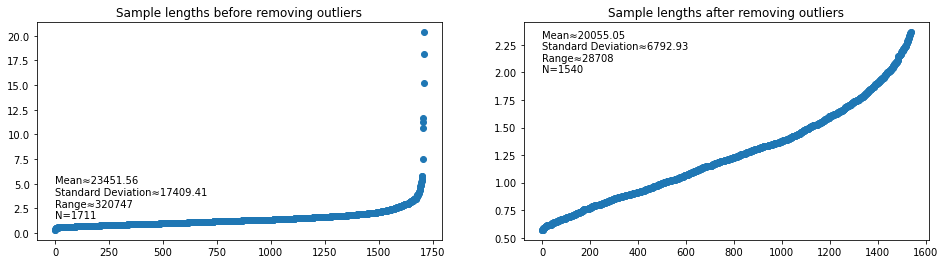

In [ ]:
#Some of the recordings are outliers (very short/long)
#so we are going to remove them

durations0 = np.sort(np.array(durations))
mean0, std0, range_val0 = np.mean(durations0), np.std(durations0), np.ptp(durations0)

num_rm = 171
ds = np.array(durations)
ds = np.abs(ds-np.mean(ds))
idc = np.argsort(ds)[:-num_rm]
n = len(idc)
durations = np.sort(np.array(durations)[idc])

mean, std, range_val = np.mean(durations), np.std(durations), np.ptp(durations)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.scatter(np.arange(durations0.shape[0]), durations0/16000)
ax1.text(0,1.5, f"Mean≈{np.around(mean0,2)}\nStandard Deviation≈{np.around(std0,2)}\nRange≈{np.around(range_val0,2)}\nN={durations0.shape[0]}")
ax2.scatter(np.arange(durations.shape[0]), durations/16000)
ax2.text(0,2, f"Mean≈{np.around(mean,2)}\nStandard Deviation≈{np.around(std,2)}\nRange≈{np.around(range_val,2)}\nN={durations.shape[0]}")
#fig.suptitle("Distribution of sample lengths with and without outliers")
ax1.title.set_text('Sample lengths before removing outliers')
ax2.title.set_text('Sample lengths after removing outliers')
fig.savefig("Data_Distribution", dpi=1000)
plt.show()


In [ ]:
name0 = np.array(name)
origin0 = np.array(origin)
number0 = np.array(number)
age0 = np.array(age)
id0 = np.array(id)
durations0 = np.array(durations)
signals0 = np.array(signals)
name = name0[idc]
origin = origin0[idc]
number = number0[idc]
age = age0[idc]
id = id0[idc]
signals = signals0[idc]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


In [ ]:
print("Before removing outliers:")
data_statistics(df)
print("\nAfter removing outliers:")
data_statistics(df.iloc[idc])

Before removing outliers:
Total Number of Samples: 1711
Number of Japanese Samples: 1173
Number of German Samples: 538
Total Number of Babies: 63
Number of Japanese Babies: 31
Number of German Babies: 32
Durations of the recordings range from 0.3180625 to 20.36475 seconds.

After removing outliers:
Total Number of Samples: 1540
Number of Japanese Samples: 1052
Number of German Samples: 488
Total Number of Babies: 63
Number of Japanese Babies: 31
Number of German Babies: 32
Durations of the recordings range from 0.570875 to 2.365125 seconds.


## Load the Eval Set

In [ ]:
#Loading the Eval Data
max_dur = np.max(durations)
min_dur = np.min(durations)

signals_eval = []
for filename in os.listdir(eval_dir):
  path     = eval_dir + '/' + filename
  signal,_ = librosa.load(path, sr=sr)
  #only append the signal, if it is not an outlier
  #All the recordings are German Babies
  if min_dur<=len(signal) and len(signal)<=max_dur:
    signals_eval.append(signal)

# Preprocess the data

## Data Augmentation

In [ ]:
def stretch(x, size = max_dur):
  #x = x.numpy()
  rate = min(tf.abs(tf.size(x)/size-1), 0.2)
  rate = float(2*rate*random.random()-rate+1)
  x = librosa.effects.time_stretch(x, rate)
  return tf.convert_to_tensor(x)

def random_pad(x, size = max_dur):
  n = size-x.shape[0]
  y = tf.zeros(n)
  x_pad = tf.concat((x, y), axis=0)
  return tf.roll(x_pad, shift = random.randint(0,n), axis=0)

def add_wn(x):
  #Change to Gaussian Noise
  wn = tf.random.normal(shape=[x.shape[0]], stddev = 0.2)
  return x + 0.05*wn

def get_spec(x, sr=16000, mel=True):
  if type(x) is not np.ndarray:
    x = x.numpy()
  S = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128, fmax=8000) if mel else tf.abs(librosa.stft(x))**2
  S_dB = librosa.power_to_db(S, ref=np.max)
  S_dB = tf.abs(S_dB)
  return tf.experimental.numpy.flipud(S_dB)

def preprocess(x, size=max_dur):
  x = stretch(x, size)
  x = random_pad(x, size)
  x = add_wn(x)
  return np.array(x)

In [ ]:
#Here we determine the IDs of German and Japanese Babys
#Next we assign the Baby Ids to train and dev set

#Find the numbers of German and Japanese Babys
num_ger = np.unique(number[np.argwhere(origin==0)])
num_jap = np.unique(number[np.argwhere(origin==1)])

#Split the German Babys into train and dev
split_ger = np.arange(num_ger.shape[0])
np.random.shuffle(split_ger)
num_ger_train, num_ger_dev, num_ger_test = np.split(num_ger[split_ger], [int(0.8*num_ger.shape[0]), int(0.9*num_ger.shape[0])])

#Split the Japanese Babys into train and dev
split_jap = np.arange(num_jap.shape[0])
np.random.shuffle(split_jap)
num_jap_train, num_jap_dev, num_jap_test = np.split(num_jap[split_jap], [int(0.8*num_jap.shape[0]), int(0.9*num_jap.shape[0])])


ger_train, ger_dev, ger_test, jap_train, jap_dev, jap_test = [],[],[],[],[],[]
for idx, sig in enumerate(signals):
  if origin[idx] == 0:
    if number[idx] in num_ger_train:
      ger_train.append(sig)
    elif number[idx] in num_ger_dev:
      ger_dev.append(sig)
    else:
      ger_test.append(sig)
  else:
    if number[idx] in num_jap_train:
      jap_train.append(sig)
    elif number[idx] in num_jap_dev:
      jap_dev.append(sig)
    else:
      jap_test.append(sig)

In [ ]:
print(f"German Train/Dev/Test samples: {len(ger_train), len(ger_dev), len(ger_test)}\n"+
      f"Japanese Train/Dev/Test samples: {len(jap_train), len(jap_dev), len(jap_test)}")

German Train/Dev/Test samples: (410, 45, 33)
Japanese Train/Dev/Test samples: (880, 91, 81)


In [ ]:
#After removing outliers, we have about 1500 Samples.
#With an 80/20 train/dev split, this leaves us with about 1200 train samples
#We will upsample the train data until we have 5000 samples for each class
#We will upsample the dev data until we have equally many samples in both classes

In [ ]:
np.array(ger_train).shape
#np.array((5*ger_train)[:n_train]).shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(410,)

## Create Training Data

In [ ]:
#Number and duration of samples
length  = int(max_dur * 1.2)
n_train = 1200

#Preprocess the German and Japanese training samples
X_train_ger = [preprocess(sig, length) for sig in ((5*ger_train)[:n_train])]
X_train_jap = [preprocess(sig, length) for sig in (5*jap_train)[:n_train]]

#Create the X_train and y_train arrays
X_train_split = np.arange(2*n_train)
np.random.shuffle(X_train_split)
X_train = np.zeros((2*n_train, length))
y_train = np.zeros(2*n_train)
X_train[X_train_split[:n_train]] = X_train_ger
X_train[X_train_split[n_train:]] = X_train_jap
y_train[X_train_split[n_train:]] = 1

#Create the spectrogram for training samples
specs_train = np.array([get_spec(x)[:120] for x in X_train])

#Create the f0 values for the training samples
f0s_train    = []
for x in X_train:
  f0, valids, _ = librosa.pyin(x, librosa.note_to_hz('C2'), librosa.note_to_hz('C7'))
  f0s_train.append(f0[valids])

max_f0 = int(np.max([f0.shape[0] for f0 in f0s_train])*1.2)
fs_train = np.zeros((X_train.shape[0], max_f0))

for idx, f0 in enumerate(f0s_train):
  f = random_pad(tf.convert_to_tensor(f0, 'float32'), max_f0)
  fs_train[idx] = f


## Create Development Data

In [ ]:
#Preprocess the German and Japanese dev samples
n_dev = max(len(ger_dev), len(jap_dev))
X_dev_ger = np.array([preprocess(sig, length) for sig in ((5*ger_dev)[:n_dev])])
X_dev_jap = np.array([preprocess(sig, length) for sig in (5*jap_dev)[:n_dev]])

#Create the spectrogram for dev samples
specs_dev_ger = np.array([get_spec(x)[:120] for x in X_dev_ger])
specs_dev_jap = np.array([get_spec(x)[:120] for x in X_dev_jap])

#Create the f0 values for the development samples
f0s_dev_ger    = []
f0s_dev_jap    = []

for x in X_dev_ger:
  f0, valids, _ = librosa.pyin(x, librosa.note_to_hz('C2'), librosa.note_to_hz('C7'))
  f0s_dev_ger.append(f0[valids])

for x in X_dev_jap:
  f0, valids, _ = librosa.pyin(x, librosa.note_to_hz('C2'), librosa.note_to_hz('C7'))
  f0s_dev_jap.append(f0[valids])

fs_dev_ger = np.zeros((X_dev_ger.shape[0], max_f0))
fs_dev_jap = np.zeros((X_dev_jap.shape[0], max_f0))


for idx, f0 in enumerate(f0s_dev_ger):
  f = random_pad(tf.convert_to_tensor(f0, 'float32'), max_f0)
  fs_dev_ger[idx] = f

for idx, f0 in enumerate(f0s_dev_jap):
  f = random_pad(tf.convert_to_tensor(f0, 'float32'), max_f0)
  fs_dev_jap[idx] = f

## Create Test Data

In [ ]:
#Preprocess the German and Japanese test samples
n_test = max(len(ger_test), len(jap_test))
X_test_ger = np.array([preprocess(sig, length) for sig in ((5*ger_test)[:n_test])])
X_test_jap = np.array([preprocess(sig, length) for sig in (5*jap_test)[:n_test]])

#Create the spectrogram for test samples
specs_test_ger = np.array([get_spec(x)[:120] for x in X_test_ger])
specs_test_jap = np.array([get_spec(x)[:120] for x in X_test_jap])

#Create the f0 values for the test samples
f0s_test_ger    = []
f0s_test_jap    = []

for x in X_test_ger:
  f0, valids, _ = librosa.pyin(x, librosa.note_to_hz('C2'), librosa.note_to_hz('C7'))
  f0s_test_ger.append(f0[valids])

for x in X_test_jap:
  f0, valids, _ = librosa.pyin(x, librosa.note_to_hz('C2'), librosa.note_to_hz('C7'))
  f0s_test_jap.append(f0[valids])

fs_test_ger = np.zeros((X_test_ger.shape[0], max_f0))
fs_test_jap = np.zeros((X_test_jap.shape[0], max_f0))


for idx, f0 in enumerate(f0s_test_ger):
  f = random_pad(tf.convert_to_tensor(f0, 'float32'), max_f0)
  fs_test_ger[idx] = f

for idx, f0 in enumerate(f0s_test_jap):
  f = random_pad(tf.convert_to_tensor(f0, 'float32'), max_f0)
  fs_test_jap[idx] = f

## Create Evaluation Data

In [ ]:
#Preprocess the eval samples
X_eval = np.array([preprocess(sig, length) for sig in signals_eval])

#Create the spectrogram for eval samples
specs_eval = np.array([get_spec(x)[:120] for x in X_eval])

#Create the f0 values for the eval samples
f0s_eval    = []
for x in X_eval:
  f0, valids, _ = librosa.pyin(x, librosa.note_to_hz('C2'), librosa.note_to_hz('C7'))
  f0s_eval.append(f0[valids])

fs_eval = np.zeros((X_eval.shape[0], max_f0))

for idx, f0 in enumerate(f0s_eval):
  f = random_pad(tf.convert_to_tensor(f0, 'float32'), max_f0)
  fs_eval[idx] = f

# Save / Load Processed Data

In [ ]:
#We use json to save the spectrograms and f0s of the produced data in order to avoid computing them every time we use the notebook.
#Helper functions
def save(data, filename):
    if type(data) is np.ndarray:
      data = data.tolist()
    with open(filename, 'w') as f:
        json.dump(data, f, ensure_ascii=False)
        
def load(filename):
    with open(filename) as data:
        x = json.load(data)
    return np.array(x)

In [ ]:
#Saving the spectrograms
save(specs_train, "/content/drive/My Drive/infant_cries/data_js_final/specs_train.json")
save(y_train, "/content/drive/My Drive/infant_cries/data_js_final/y_train.json")
save(specs_dev_ger, "/content/drive/My Drive/infant_cries/data_js_final/specs_dev_ger.json")
save(specs_dev_jap, "/content/drive/My Drive/infant_cries/data_js_final/specs_dev_jap.json")
save(specs_test_ger, "/content/drive/My Drive/infant_cries/data_js_final/specs_test_ger.json")
save(specs_test_jap, "/content/drive/My Drive/infant_cries/data_js_final/specs_test_jap.json")
save(specs_eval, "/content/drive/My Drive/infant_cries/data_js_final/specs_eval.json")

In [ ]:
#Saving the f0s
save(fs_train, "/content/drive/My Drive/infant_cries/data_js_final/fs_train.json")
save(fs_dev_ger, "/content/drive/My Drive/infant_cries/data_js_final/fs_dev_ger.json")
save(fs_dev_jap, "/content/drive/My Drive/infant_cries/data_js_final/fs_dev_jap.json")
save(fs_test_ger, "/content/drive/My Drive/infant_cries/data_js_final/fs_test_ger.json")
save(fs_test_jap, "/content/drive/My Drive/infant_cries/data_js_final/fs_test_jap.json")
save(fs_eval, "/content/drive/My Drive/infant_cries/data_js_final/fs_eval.json")

In [ ]:
#Saving the wavs
save(X_train, "/content/drive/My Drive/infant_cries/data_js_final/X_train.json")
save(X_dev_ger, "/content/drive/My Drive/infant_cries/data_js_final/X_dev_ger.json")
save(X_dev_jap, "/content/drive/My Drive/infant_cries/data_js_final/X_dev_jap.json")
save(X_test_ger, "/content/drive/My Drive/infant_cries/data_js_final/X_test_ger.json")
save(X_test_jap, "/content/drive/My Drive/infant_cries/data_js_final/X_test_jap.json")
save(X_eval, "/content/drive/My Drive/infant_cries/data_js_final/X_eval.json")